# 图像字幕大师

本项目会通过keras搭建一个深度卷积神经网络来为图片生成一行字幕

## 数据集


采用数据集：MS COCO dataset

下载地址：http://cocodataset.org/


In [4]:
import os
import json
import keras
from keras.applications.resnet import ResNet50,preprocess_input
from keras.models import Model,Sequential
from keras.preprocessing import image
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras.layers import Input,Dense,Lambda,LSTM,GRU,Bidirectional,RepeatVector,ReLU,Flatten,TimeDistributed,Softmax,Embedding,Concatenate
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import EarlyStopping,ModelCheckpoint
import numpy as np
from matplotlib import pyplot as plt 
import h5py

Using TensorFlow backend.


##  读取数据

In [31]:
train_dir = r'images/train2014/'
val_dir = r'images/val2014/'
test_dir = r'images/test2014/'
train_datas = json.load(open('train.json'))
val_datas = json.load(open('val.json'))

In [30]:
print(json.dumps(list(train_datas.items())[:3], ensure_ascii=False,indent=4))

[
    [
        "42237",
        {
            "filename": "COCO_train2014_000000045954.jpg",
            "caption": "客机的照片的关闭。",
            "caption_en": "A close up photo of a passenger plane."
        }
    ],
    [
        "636850",
        {
            "filename": "COCO_train2014_000000552149.jpg",
            "caption": "走横跨一个草覆盖的领域的斑马。.",
            "caption_en": "A zebra walking across a grass covered field."
        }
    ],
    [
        "79418",
        {
            "filename": "COCO_train2014_000000138629.jpg",
            "caption": "一个人正坐在餐桌旁，上面有一个巨大的比萨。",
            "caption_en": "A man is at a dining table with a huge pizza."
        }
    ]
]


In [29]:
print(json.dumps(list(val_datas.items())[:3], ensure_ascii=False,indent=4))

[
    [
        "70570",
        {
            "filename": "COCO_val2014_000000323288.jpg",
            "caption": "一个大老人坐一个长木凳在公园。",
            "caption_en": "A large older man sitting on a wooden bench in a park."
        }
    ],
    [
        "822590",
        {
            "filename": "COCO_val2014_000000453104.jpg",
            "caption": "长颈长颈鹿在天空中抬起头",
            "caption_en": "a long necked giraffe raises its head in the sky "
        }
    ],
    [
        "587216",
        {
            "filename": "COCO_val2014_000000182369.jpg",
            "caption": "使用与一个球的一头北极熊在一个小池塘区域。",
            "caption_en": "A polar bear playing with a ball in a small pond area."
        }
    ]
]


## 序列化 文本编码

In [10]:
class Tokenizer():
    def __init__(self):
        self.maxlen = 0
        self.index_to_words = dict()
        self.word_index = dict()
        self.word_index['<start>'] = 0
        self.word_index['<end>'] = 1
        self.word_index['<unk>'] = 2
    def fit_on_texts(self,texts):
        for text in texts:
            for word in text:
                if word not in self.word_index:
                    self.word_index[word] = len(self.word_index)
        self.maxlen = max([len(text) for text in texts])
        self.maxlen =  50 if self.maxlen > 50 else self.maxlen
        self.index_to_words = {_id:word for word,_id in self.word_index.items()}

    def texts_to_sequences(self,texts):
        seqs = list()
        for text in texts: 
            seq = [0]
            for word in text:
                seq.append(self.word_index.get(word, 2))
            seq = seq + [1] * (self.maxlen + 2 - len(seq))
            if len(seq)>self.maxlen+2:
                seq = seq[:self.maxlen+2]
            seqs.append(seq)
        return np.array(seqs)
    
    def sequence_to_text(self,sequence):
        return ''.join([self.index_to_words[index] for index in sequence])


def preprocessing(datas:dict(),tokenizer=None,maxlen=None):
    texts = [v['caption'] for k,v in datas.items()]
    filenames = np.array([v['filename'] for k,v in datas.items()])
    if tokenizer is None:
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
#     if maxlen is None:
#         maxlen = max([len(sentence) for sentence in sequences])
#     sequences = pad_sequences(sequences,maxlen=maxlen,padding='post')
#     sequences = np.expand_dims(sequences,axis=2)
    return sequences,tokenizer,filenames

In [11]:
train_datas = json.load(open('train.json'))
train_tokenized,tokenizer,train_filenames = preprocessing(train_datas)
print(len(tokenizer.word_index))

3346


In [12]:
val_tokenized,_,val_filenames = preprocessing(val_datas,
                                              tokenizer=tokenizer,
                                              maxlen=train_tokenized.shape[1])
print(list(train_datas.items())[:2])
print(list(val_datas.items())[:2])
print(train_tokenized.shape)
print(val_tokenized.shape)
print(list(tokenizer.word_index.items())[:6])
print(train_tokenized[1])
print(val_tokenized[1])

[('42237', {'filename': 'COCO_train2014_000000045954.jpg', 'caption': '客机的照片的关闭。', 'caption_en': 'A close up photo of a passenger plane.'}), ('636850', {'filename': 'COCO_train2014_000000552149.jpg', 'caption': '走横跨一个草覆盖的领域的斑马。.', 'caption_en': 'A zebra walking across a grass covered field.'})]
[('70570', {'filename': 'COCO_val2014_000000323288.jpg', 'caption': '一个大老人坐一个长木凳在公园。', 'caption_en': 'A large older man sitting on a wooden bench in a park.'}), ('822590', {'filename': 'COCO_val2014_000000453104.jpg', 'caption': '长颈长颈鹿在天空中抬起头', 'caption_en': 'a long necked giraffe raises its head in the sky '})]
(414113, 52)
(202654, 52)
[('<start>', 0), ('<end>', 1), ('<unk>', 2), ('客', 3), ('机', 4), ('的', 5)]
[ 0 11 12 13 14 15 16 17 18  5 19 20  5 21 22 10 23  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1]
[  0 183 199 183 199 200  27 266 116  68 752  40  63   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1

##  加载图像


In [20]:
def load_imgs(image_dir:str,filenames):
    imgs = list()
    for filename in filenames:
        img = load_img(os.path.join(image_dir,filename),target_size=(244,244))
        img = image.img_to_array(img)
        imgs.append(img)
    imgs = np.stack(imgs)
    return imgs.astype(np.int32)

### 特征提取模型:ResNet50

In [22]:
def get_preprocess_model():
    input_tensor = Input((244, 244, 3))
    input_tensor = Lambda(preprocess_input)(input_tensor)
    base_model = ResNet50(input_tensor=input_tensor, weights='imagenet', pooling='max', include_top=False)
    output = base_model.output
    return Model(base_model.input, output)
preprocess_model = get_preprocess_model()

## 特征提取

In [6]:
def save_preprocess(image_dir:str, filenames, model,savename:str):
    batch_size = 16
    filenames = set(filenames)
    filenames = list(filenames)
    print('处理%d条数据' % len(filenames))
    with h5py.File(savename, 'a') as f:
        while len(filenames) > 0:
            print('\r剩余%d' % len(filenames), end=' ')
            batch_filenames = filenames[-batch_size:]
            for _ in range(batch_size):
                if len(filenames) > 0:
                    filenames.pop()
            imgs = load_imgs(image_dir, batch_filenames)
            features = model.predict(imgs)
            for filename, feature in zip(batch_filenames, features):
                f.create_dataset(filename,data=feature)
# save_preprocess(train_dir, train_filenames, preprocess_model,'train_preprocess.hdf5')
# print('训练集处理完成')
# save_preprocess(val_dir, val_filenames, preprocess_model,'val_preprocess.hdf5')
# print('验证集处理完成')
    
    

In [13]:

def load_features(preprocess_filename:str, imagefilenames):
    with h5py.File(preprocess_filename, "r") as f:
        features = list()
        for filename in imagefilenames:
            features.append(np.array(f[filename]))
        features = np.array(features)
        return features
            

## 数据生成器

为训练模型提供数据生成器；

注：不训练模型不要运行

In [14]:
def generator(preprocess_filename:str,filenames,sequences,batch_size=32):
    assert len(filenames) == len(sequences)
    buffer = 1
    while True:
        batch_index = np.random.choice(len(filenames),size=batch_size,replace=False)
        batch_filenames = filenames[batch_index]
        batch_sequences = sequences[batch_index]
        features = load_features(preprocess_filename, batch_filenames)
        y_seqs = np.expand_dims(batch_sequences,axis=2)
        yield [features, batch_sequences[:,:-1]], y_seqs

In [8]:
batch_size = 16
train_gen = generator('train_preprocess.hdf5', train_filenames, train_tokenized,batch_size=batch_size)
val_gen = generator('val_preprocess.hdf5', val_filenames, val_tokenized,batch_size=batch_size)
for (features,x_seqs),y_seqs in train_gen:
    print(features.shape)
    print(x_seqs.shape)
    print(y_seqs.shape)
    print(tokenizer.sequence_to_text(x_seqs[0]))
    break

(16, 2048)
(16, 51)
(16, 52, 1)
<start>一块白板，内含一片比萨饼和一些调味料。<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>


## 定义模型

In [15]:
def caption_model(output_sequence_length:int,vocab_size:int,hidden_size:int=128,embed_size:int=128):
    def expand_dims_layer(x,axis=-1):
        return keras.backend.expand_dims(x, axis=axis)
    def argmax_layer(x,axis=-1):
        return keras.backend.argmax(x, axis=axis) 
    def expand_dims_layer(x,axis=-1):
        return keras.backend.expand_dims(x, axis=axis)

    input_features = Input((2048,))
    features = Dense(embed_size)(input_features)
    features = Lambda(expand_dims_layer,arguments={'axis':1})(features)
    input_seqs = Input((output_sequence_length-1,))
    embed_layer = Embedding(vocab_size,embed_size)
    embeds = embed_layer(input_seqs)
    lstm_inputs = Concatenate(axis=1)([features, embeds])
    lstm_layer = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.2)
    lstm_output,_,_ = lstm_layer(lstm_inputs)
    dense_layer = Dense(vocab_size)
    output = TimeDistributed(dense_layer)(lstm_output)
    output = Softmax()(output)
    train_model = Model([input_features, input_seqs],output)
    
    
    lstm_inputs = features
    initial_state = None
    output_seqs = list()
    for i in range(output_sequence_length):
        print('\r', i, end='')
        lstm_output,state_h,state_c = lstm_layer(lstm_inputs,initial_state)
        lstm_output = Flatten()(lstm_output)
        output = dense_layer(lstm_output)
        word_index = Lambda(argmax_layer,arguments={'axis':1})(output)
        embeds = embed_layer(word_index)
        lstm_inputs = Lambda(expand_dims_layer,arguments={'axis':1})(embeds)
        initial_state = (state_h,state_c)
        output_seqs.append(word_index)
    predict_model = Model(input_features,output_seqs)
    return train_model,predict_model

vocab_size = len(tokenizer.word_index) # 3346
output_sequence_length = 52
#train_model, predict_model = caption_model(train_tokenized.shape[1], len(tokenizer.word_index), hidden_size=512,embed_size=512)
train_model, predict_model = caption_model(output_sequence_length, vocab_size, hidden_size=512,embed_size=512)
print('\r模型准备完成')
train_model.summary()
predict_model.summary()

模型准备完成
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          1049088     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 51)           0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1, 512)       0           dense_1[0][0]                    
_____________________________________________________________________________________

## 加载模型

In [16]:
#model_file = 'weight/42/ep071val_loss0.433val_acc0.865.h5'
model_file = 'weight/ep071val_loss0.433val_acc0.865.h5'
train_model.load_weights(model_file)

# 格式化输出结果
cleantxt = lambda x:x.replace('<start>','').replace('<end>','')

## 训练模型

In [11]:
lr = 0.0001
train_model.compile(loss = sparse_categorical_crossentropy, 
              optimizer = Adam(lr), 
              metrics = ['accuracy'])
mc = ModelCheckpoint(filepath=r'weight\ep{epoch:03d}val_loss{val_loss:.3f}val_acc{val_accuracy:.3f}.h5',
                     save_best_only=True, save_weights_only=True, verbose=1)
es = EarlyStopping(monitor='loss',patience=4, min_delta=0.001, verbose=1)
his = train_model.fit_generator(generator=train_gen,
                    steps_per_epoch=6000,
                    epochs=1000,
                    callbacks=[mc,es],
                    validation_data=val_gen,
                    validation_steps=300)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/1000
6000/6000 [==============================] - 957s 160ms/step - loss: 1.5070 - accuracy: 0.7567 - val_loss: 0.9899 - val_accuracy: 0.7924

Epoch 00001: val_loss improved from inf to 0.98992, saving model to weight\ep001val_loss0.990val_acc0.792.h5
Epoch 2/1000
6000/6000 [==============================] - 1006s 168ms/step - loss: 1.0652 - accuracy: 0.8061 - val_loss: 0.9722 - val_accuracy: 0.8147

Epoch 00002: val_loss improved from 0.98992 to 0.97216, saving model to weight\ep002val_loss0.972val_acc0.815.h5
Epoch 3/1000
6000/6000 [==============================] - 1006s 168ms/step - loss: 0.9374 - accuracy: 0.8224 - val_loss: 0.8737 - val_accuracy: 0.8273

Epoch 00003: val_loss improved from 0.97216 to 0.87371, saving model to weight\ep003val_loss0.874val_acc0.827.h5
Epoch 4/1000
6000/6000 [==============================] - 1056s 176ms/step - loss: 0.8740 - accuracy: 0.8309 - val_

6000/6000 [==============================] - 1006s 168ms/step - loss: 0.5795 - accuracy: 0.8705 - val_loss: 0.5528 - val_accuracy: 0.8658

Epoch 00075: val_loss did not improve from 0.43348
Epoch 76/1000
6000/6000 [==============================] - 1002s 167ms/step - loss: 0.5777 - accuracy: 0.8708 - val_loss: 0.5653 - val_accuracy: 0.8666

Epoch 00076: val_loss did not improve from 0.43348
Epoch 77/1000
6000/6000 [==============================] - 998s 166ms/step - loss: 0.5772 - accuracy: 0.8709 - val_loss: 0.6109 - val_accuracy: 0.8659

Epoch 00077: val_loss did not improve from 0.43348
Epoch 78/1000
6000/6000 [==============================] - 998s 166ms/step - loss: 0.5749 - accuracy: 0.8714 - val_loss: 0.6429 - val_accuracy: 0.8655

Epoch 00078: val_loss did not improve from 0.43348
Epoch 79/1000
6000/6000 [==============================] - 1005s 167ms/step - loss: 0.5764 - accuracy: 0.8708 - val_loss: 0.7292 - val_accuracy: 0.8666

Epoch 00079: val_loss did not improve from 0.43

##  画出训练曲线图像

训练完成后画出训练曲线图

注：未训练完成不要运行

In [ ]:
begin = 10
loss=his.history['loss'][begin:]
val_loss=his.history['val_loss'][begin:]
plt.plot(range(begin+1 , begin + 1 + len(loss)),loss,color='red')
plt.plot(range(begin+1 , begin + 1 + len(val_loss)),val_loss,color='blue')
plt.legend(labels=['loss','val_loss',])

## 验证集预测

在验证集上进行预测，对比结果；

预测: <start>一个人坐在长凳上，看着他的手机。<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>
真实: <start>一个大老人坐一个长木凳在公园。<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>


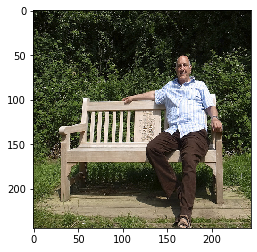

预测: <start>一只长颈鹿在树旁边的草地上行走。<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>
真实: <start>长颈长颈鹿在天空中抬起头<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>


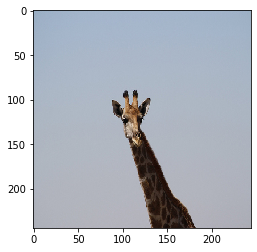

预测: <start>一只北极熊在水中游泳。<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>
真实: <start>使用与一个球的一头北极熊在一个小池塘区域。<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>


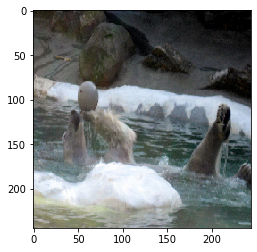

预测: <start>一个人在一家餐馆的桌子上的比萨饼。<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>
真实: <start>这似乎在比萨饼上有很多明显的配料。<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>


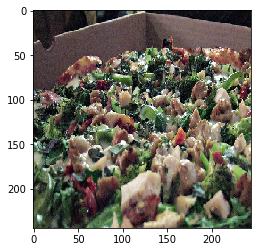

预测: <start>一个人在船上的水中<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>
真实: <start>举行在小船的几个人伞的骑马。<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>


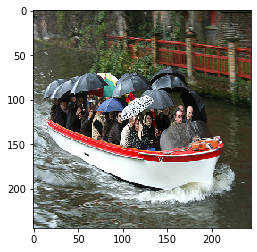

预测: <start>棒球运动员在球场上挥舞蝙蝠<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>
真实: <start>在比赛期间，拿着棒的一个人击中接baseball而来的棒球。<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>


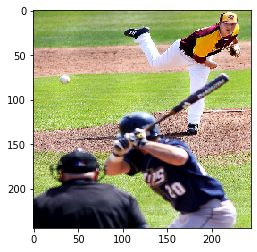

预测: <start>一列火车在铁轨上行驶。<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>
真实: <start>坐在铁轨上的涂鸦火车<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>


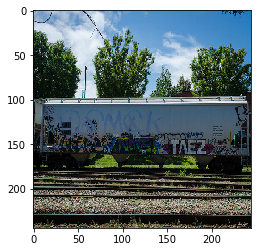

预测: <start>一个人在市场上购买水果。<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>
真实: <start>一个穿着棕色衬衫的女人购物<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>


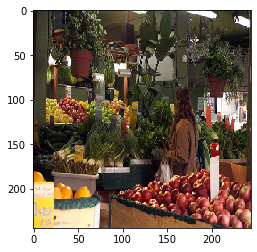

预测: <start>一个花瓶花坐在桌子上。<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>
真实: <start>一个花瓶里放着美丽的花。<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>


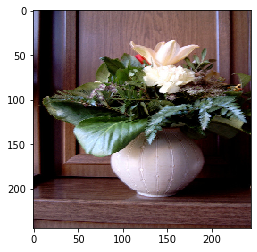

预测: <start>一群斑马在草地上行走。<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>
真实: <start>一些斑马污垢高大的棕色草丛和树木<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>


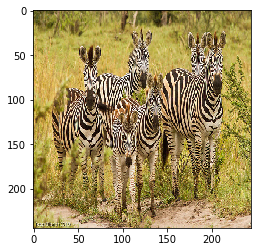

In [15]:
imgs = load_imgs(val_dir ,val_filenames[:10])
features = load_features('val_preprocess.hdf5', val_filenames[:10])
texts = val_tokenized[:10]
predicts = predict_model.predict(features)
predicts = np.array(predicts)
predicts = np.transpose(predicts,axes=(1,0))

for predict,img,text in zip(predicts,imgs,texts) :
    print('预测:',tokenizer.sequence_to_text(predict))
    print('真实:',tokenizer.sequence_to_text(text))
    plt.imshow(img)
    plt.show()


##  测试集数据验证

<start>一只黑白猫在汽车的后视镜中。<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>


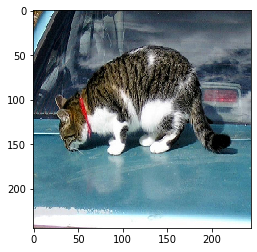

<start>一个人在船上的水中<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>


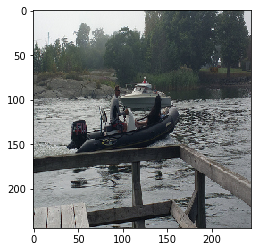

<start>一个人在海洋中的冲浪板上。<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>


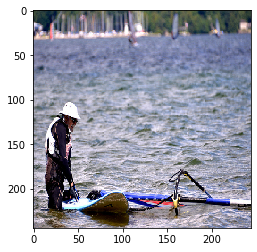

<start>一个停车灯，上面有一个停车标志。<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>


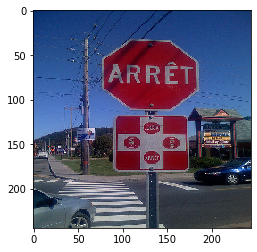

<start>一辆白色的公共汽车停在一个停车场。<end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end><end>


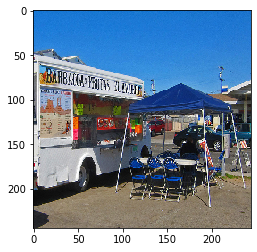

In [20]:
# 测试结果
test_dir = r'images/test2014/'
test_filenames = os.listdir(test_dir)
# 随机选5张
indexs = np.random.choice(len(test_filenames), size=5, replace=False)
imgs = load_imgs(test_dir ,np.array(test_filenames)[indexs])
features = preprocess_model.predict(imgs)
predicts = predict_model.predict(features)
predicts = np.array(predicts)
predicts = np.transpose(predicts,axes=(1,0))
for predict,img in zip(predicts,imgs):
    print(tokenizer.sequence_to_text(predict))
    plt.imshow(img)
    plt.show()

## 实际应用：预测图像

把待预测的图像放到 'test'目录下，批量进行预测

正在预测图像...


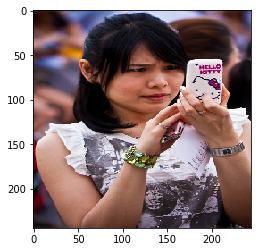

预测结果: 一个人在他的手机上聊天，而一个人在他的手机上聊天。
----------------------------------------


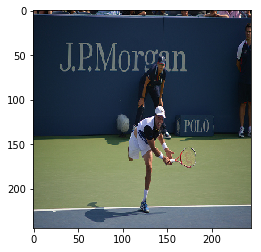

预测结果: 一个人在网球上荡秋千
----------------------------------------


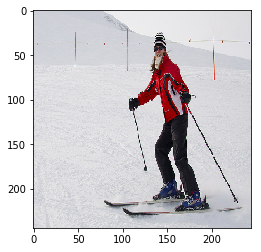

预测结果: 一个人在雪地上骑滑雪板
----------------------------------------


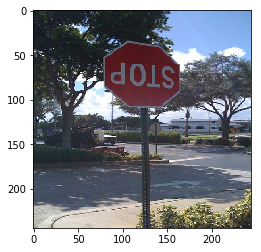

预测结果: 在一个停车牌的一个停车牌在街道上。
----------------------------------------


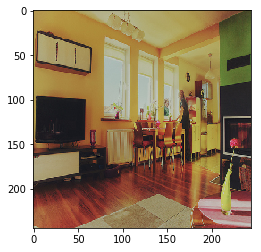

预测结果: 一个带有大窗户的客厅，里面有一个大窗户。
----------------------------------------


In [25]:
# 批量预测图像调用方法 
def predict_image(imgs):
    features = preprocess_model.predict(imgs)
    predicts = predict_model.predict(features)
    predicts = np.array(predicts)
    predicts = np.transpose(predicts,axes=(1,0))
    pred_txts = [cleantxt(tokenizer.sequence_to_text(predict)) for predict in predicts]
    return pred_txts

test_dir = r'test/'
test_filenames = os.listdir(test_dir)
#indexs = np.random.choice(len(test_filenames), size=5, replace=False)
imgs = load_imgs(test_dir, np.array(test_filenames))
print('正在预测图像...')
pred_txts = predict_image(imgs)
for pred_txt,img in zip(pred_txts,imgs):
    print('-'*40)
    plt.imshow(img.astype(np.uint8))
    plt.show()
    print('预测结果:',pred_txt)

